- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datios Intelia

In [2]:
!ls data

customers.csv  products.csv  relation.csv


In [3]:
dataPath = "data/"

users = pd.read_csv(dataPath + "customers.csv")
items = pd.read_csv(dataPath + "products.csv")
pairs = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_667/3077265193.py:3: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv(dataPath + "customers.csv")
/tmp/ipykernel_667/3077265193.py:4: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  items = pd.read_csv(dataPath + "products.csv")


# Compañía 23

In [4]:
pairs = pairs[ pairs.company_id == 23].copy()
users = users[ users.company_id == 23].copy()
items = items[ items.company_id == 23].copy()

# <center> Train with fast.ai

In [5]:
from recommenderSystemFastai import RecSysFastai

In [6]:
rs = RecSysFastai(pairs)

<AxesSubplot:ylabel='Frequency'>

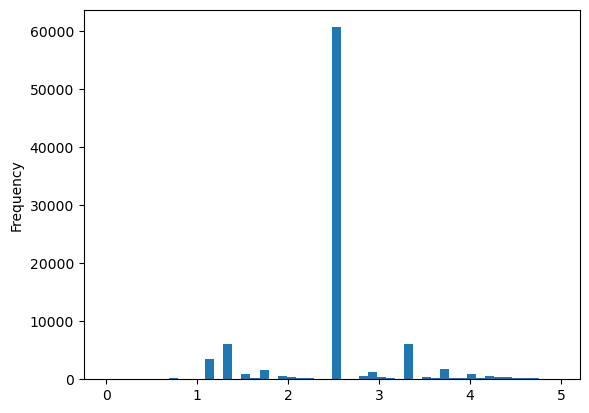

In [7]:
rs.df.peso.plot.hist(bins=50)

In [8]:
rs.entrenar_modelo(valid_pct=0.2)

epoch,train_loss,valid_loss,mae,time
0,0.321107,0.303288,0.347003,00:04
1,0.248994,0.276115,0.334609,00:04
2,0.149933,0.280831,0.345401,00:04
3,0.079485,0.280596,0.343650,00:04
4,0.043152,0.281384,0.344921,00:04


In [9]:
rs.entrenar_modelo(valid_pct=0)

epoch,train_loss,valid_loss,mae,time
0,0.300356,None,None,00:04
1,0.266344,None,None,00:04
2,0.168183,None,None,00:04
3,0.092178,None,None,00:04
4,0.054893,None,None,00:04


/home/javi/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/home/javi/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/home/javi/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/home/javi/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/home/javi/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


### Ver id usuarios

In [10]:
rs.users[:10]

(#10) ['#na#',101038,101039,101040,101041,101042,101043,101045,101046,101047]

### Ver id porductos

In [11]:
rs.items[:10]

(#10) ['#na#',28883,28888,28890,28891,28892,28893,28894,28895,28897]

### Sugerencias (ids de producto) para un usario concreto.

In [12]:
rs.sugerirProdutos(user_ids=[101038], limit=0.5)

(#2) [57610,52155]

### Sugerencias (ids de producto) para ciertos usarios filtrados.

In [13]:
rs.sugerirProdutos(user_ids=[101038,101039,101040], limit=0.5)

(#0) []

### Audiencia (ids de usuarios) para un producto concreto.

In [14]:
rs.adienciaUsuaros(item_ids=[28883], limit=0.88)

(#0) []

### Audiencia (ids de usuarios) para ciertos productos filtrados.

In [15]:
rs.adienciaUsuaros(item_ids=[28883,28888,28890], limit=0.2)

(#2417) [102964,113848,107716,120575,118897,102474,519025,114131,118627,114889...]

### Ids de producto que normalmente se compran junto a este producto.

In [16]:
rs.productos_parecidos(item_ids=[28883], limit=0.3)

(#443) [28883,28959,57755,55086,53325,56734,51889,55809,50550,54931...]

---
# <center> Train with SGD from scratch

In [17]:
from recommenderSystem import RecSys

In [18]:
rs2 = RecSys(pairs, users, items, userName="customer_id", itemName="product_id", scoreName="peso")

In [19]:
#rs2.draw_matrix()

In [20]:
split_idx = int(len(rs2.samples) * 0.8)
#np.random.shuffle(self.samples)
train_samples = rs2.samples[:split_idx]
valid_samples = rs2.samples[split_idx:]

train_log = rs2.entrenar_modelo_manualmente(
    train_samples = train_samples,
    valid_samples = valid_samples,
    embSize = 50,
    lr = 0.01,
    wd = 0.1,
    epochs=50)

Epoch: 1 ; trMAE = 0.2745 trMSE = 0.2480 valMAE = 0.5085 valMSE = 0.5376
Epoch: 2 ; trMAE = 0.2750 trMSE = 0.2326 valMAE = 0.5001 valMSE = 0.5205
Epoch: 3 ; trMAE = 0.2754 trMSE = 0.2235 valMAE = 0.4952 valMSE = 0.5109
Epoch: 4 ; trMAE = 0.2746 trMSE = 0.2172 valMAE = 0.4908 valMSE = 0.5035
Epoch: 5 ; trMAE = 0.2738 trMSE = 0.2123 valMAE = 0.4884 valMSE = 0.4986
Epoch: 6 ; trMAE = 0.2726 trMSE = 0.2085 valMAE = 0.4854 valMSE = 0.4928
Epoch: 7 ; trMAE = 0.2706 trMSE = 0.2052 valMAE = 0.4841 valMSE = 0.4908
Epoch: 8 ; trMAE = 0.2706 trMSE = 0.2028 valMAE = 0.4831 valMSE = 0.4874
Epoch: 9 ; trMAE = 0.2721 trMSE = 0.2004 valMAE = 0.4840 valMSE = 0.4886
Epoch: 10 ; trMAE = 0.2720 trMSE = 0.1984 valMAE = 0.4837 valMSE = 0.4874
Epoch: 11 ; trMAE = 0.2701 trMSE = 0.1965 valMAE = 0.4835 valMSE = 0.4870
Epoch: 12 ; trMAE = 0.2694 trMSE = 0.1950 valMAE = 0.4828 valMSE = 0.4851
Epoch: 13 ; trMAE = 0.2681 trMSE = 0.1936 valMAE = 0.4826 valMSE = 0.4845
Epoch: 14 ; trMAE = 0.2682 trMSE = 0.1923 valMA

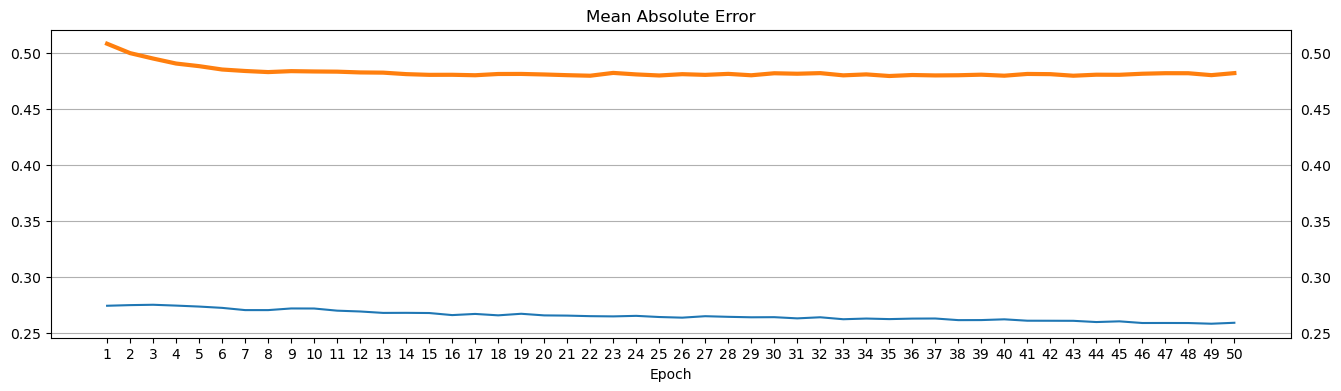

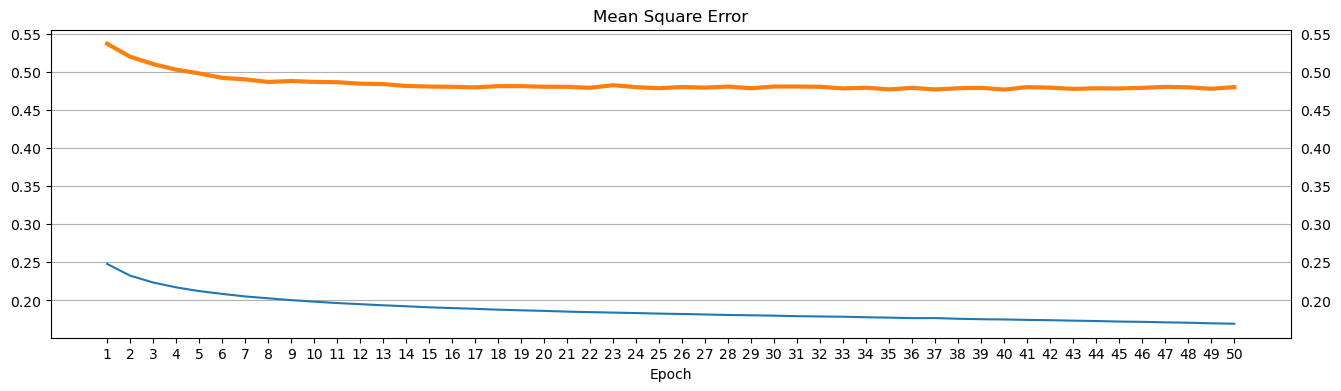

In [21]:
rs2.plot_training(train_log)

In [22]:
train_log = rs2.entrenar_modelo_manualmente(
    train_samples = rs2.samples,
    valid_samples = None,
    embSize = 50,
    lr = 0.01,
    wd = 0.1,
    epochs=50)

Epoch: 1 ; trMAE = 0.3146 trMSE = 0.2837
Epoch: 2 ; trMAE = 0.3090 trMSE = 0.2633
Epoch: 3 ; trMAE = 0.3067 trMSE = 0.2521
Epoch: 4 ; trMAE = 0.3050 trMSE = 0.2445
Epoch: 5 ; trMAE = 0.3047 trMSE = 0.2385
Epoch: 6 ; trMAE = 0.3030 trMSE = 0.2339
Epoch: 7 ; trMAE = 0.3013 trMSE = 0.2301
Epoch: 8 ; trMAE = 0.3005 trMSE = 0.2270
Epoch: 9 ; trMAE = 0.3002 trMSE = 0.2246
Epoch: 10 ; trMAE = 0.2981 trMSE = 0.2223
Epoch: 11 ; trMAE = 0.2978 trMSE = 0.2202
Epoch: 12 ; trMAE = 0.2976 trMSE = 0.2183
Epoch: 13 ; trMAE = 0.2963 trMSE = 0.2165
Epoch: 14 ; trMAE = 0.2960 trMSE = 0.2153
Epoch: 15 ; trMAE = 0.2953 trMSE = 0.2137
Epoch: 16 ; trMAE = 0.2953 trMSE = 0.2127
Epoch: 17 ; trMAE = 0.2946 trMSE = 0.2114
Epoch: 18 ; trMAE = 0.2950 trMSE = 0.2104
Epoch: 19 ; trMAE = 0.2945 trMSE = 0.2094
Epoch: 20 ; trMAE = 0.2932 trMSE = 0.2084
Epoch: 21 ; trMAE = 0.2938 trMSE = 0.2077
Epoch: 22 ; trMAE = 0.2938 trMSE = 0.2070
Epoch: 23 ; trMAE = 0.2925 trMSE = 0.2060
Epoch: 24 ; trMAE = 0.2913 trMSE = 0.2052
E

### Sugerencias (ids de producto) para un usario concreto.

In [23]:
rs2.sugerirProds_a_usuarioConcreto(user_id=101038, limit=0.3)

array([ 53117,  57238,  58052,  56062,  53388,  52979,  51741,  53907,
        55794,  57084,  53496,  52756,  58066,  56613,  56329,  53465,
        53705,  55274,  54622,  52637,  29028,  51519,  55320,  53766,
        51603,  50737,  54815,  54304,  54413,  55250,  55277,  58391,
        58229,  52363,  50402,  56899,  52950,  51834,  58429,  58492,
        50940,  56323,  52769,  54023,  52162,  52841,  51540,  51938,
        52473,  57718,  53116,  51527,  55396,  56139,  58286,  58904,
        54295,  50483,  58149,  53666,  58414,  54392,  29098,  53239,
        52333,  51332,  56612,  52741,  51913,  55868,  53118,  53015,
       117245,  57681,  54873,  57016,  54213,  52468,  53041,  29150,
        56255,  51329,  54827, 112476,  53473,  53126,  51405,  56246,
        56465,  56928,  54176,  52102,  50405,  50429,  52241,  54883,
        54310,  51386,  52962,  54084,  55963,  57371,  52974,  51302,
        55511,  54047,  58289,  52922,  54195,  56837,  57147,  53625,
      

### Sugerencias (ids de producto) para ciertos usarios filtrados.

In [24]:
rs2.sugerirProds_a_usuariosFiltrados(user_ids=[101038,101039,101040], limit=0.3)

array([ 52979,  51332,  52333, 126823,  57319,  54326,  50506,  56465,
        58052,  58405,  55794,  53431,  55868,  55401,  56917,  55732,
        57433,  56468,  52841,  53806,  75602,  57599,  50646,  51304,
        53015, 111022,  58904,  52120,  52189,  53766,  56632,  54913,
        55806,  52950,  56809,  51415,  51550,  52019,  51548,  51385,
        52058,  52157,  50690,  55320,  58611,  50599,  52705,  54413,
        52983,  50444,  56613,  29173,  50804,  53496,  52880,  54957,
        50635,  58680,  57719,  56433,  53633,  29165,  57992,  52086,
        53130,  52316,  52637,  51913,  50423,  56124,  52151,  54939,
        50391,  55027,  54310, 125324,  52160,  56342,  53388,  50791,
        51296,  52822,  55545,  54304,  53478,  54431,  54671,  51799,
        55490,  58876,  54047,  28894,  56777,  52662,  58286])

### Audiencia (ids de usuarios) para un producto concreto.

In [25]:
rs2.adienciaUsuaros_de_productoConcreto(item_id=28883, limit=0.4)

array([101389, 109343, 113148, 530589, 106449, 101559, 104043, 121160,
       113817, 115938, 116507, 101381, 110696, 111781, 104523, 111335,
       105219, 106995, 108580, 119475, 109754, 104923, 101139, 102443,
       102425, 103755, 107113, 106680, 101168, 102146, 111864, 117918,
       120648, 119715, 106350, 109941, 105205, 104894, 105540, 119825,
       140979, 109959, 109463])

### Audiencia (ids de usuarios) para ciertos productos filtrados.

In [26]:
rs2.adienciaUsuaros_de_productosFiltrados(item_ids=[28883,28888,28890], limit=0.4)

array([105129, 115560, 102425, 165260, 102130, 102437, 101093, 536242,
       113817, 107534, 102541, 115343, 113066, 113861, 115261, 105540,
       116465, 110838, 112944, 117760, 103036, 101771, 121077, 107798,
       109289])

### Ids de producto que normalmente se compran junto a este producto.

In [27]:
rs2.productos_parecidos(item_id=28883, limit=0.3)

array([ 28883,  50452,  56723,  52909,  54674,  52196,  51481,  54129,
        54725, 107216,  52199,  51886,  55036,  53289,  52963,  58307,
        53456,  52388,  54205,  55947,  50619,  57154,  54930,  50516,
        52288,  57182,  50674,  54379,  80089,  50553, 126752,  52728,
        57929,  52357,  57391,  52107,  56626,  53699,  51953,  55927,
        52197,  57338,  52232,  50570,  53199,  54237,  58825,  54246,
        54200,  53835,  53643,  28924,  57571,  51918,  53039,  56197,
        54429,  56316,  57519,  51622,  55707,  52116,  56277,  55315,
        56018,  53294,  57416,  57083,  57111,  51763,  58499,  58143,
        56617,  50441,  50432,  55533,  58530,  54698,  55810,  52101,
        53800,  57732,  52252,  58085,  56504,  54762,  51448,  52788,
        51802,  56699,  53069,  56727,  52924,  56336,  54610,  28964,
        54223,  29003,  51832,  52679,  50931,  56978,  51578,  50740,
        54792,  53006,  58142, 116538,  55582, 116411,  54022,  51737,
      